In [1]:
import random as rd
import astropy.io.fits as apf
import batman
import eleanor
import emcee
import getpass
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.backends.backend_pdf import PdfPages
from multiprocessing import Pool
from multiprocessing import Process
import multiprocessing
import numpy as np
import os
import pandas as pd
import shutil
import time as tm 
from astroquery.mast import Catalogs
import astropy.units as units
from astropy.wcs import WCS
import math
import astropy.io.fits as apf
from astropy.stats import sigma_clip
import warnings
warnings.filterwarnings("ignore")
from wotan import flatten
import lightkurve as lk
import corner
import numpy as np
import juliet
import matplotlib.gridspec as gridspec
import mpl_axes_aligner

from astropy.timeseries import BoxLeastSquares
from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter, SVOFilter
from ldtk.filters import tess, sdss_z
from astroquery import svo_fps

import mr_forecast as mr
import numba
from math import floor
from functools import partial


from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )


import itertools

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


In [2]:
from tqdm.auto import tqdm

import ntpath

LDC_for_quadratic = pd.read_csv('./LDC_files/table15.dat', 
                                header = None, 
                                sep="\s+", index_col=None,
                               names = ['logg', 'Teff', 'z','L/HP', 'aLSM', 'bLSM',
                                       'aFCM', 'bFCM', 'SQRT(CHI2)', 'qsr', 'PC'])

mdwarf_LDC_for_quadratic = LDC_for_quadratic[LDC_for_quadratic['Teff']<4300]
                  



In [3]:
def transit_mask(t, period, duration, T0):
    
    # Works with numba, but is not faster
    mask = np.abs((t - T0 + 0.5 * period) % period - 0.5 * period) < 0.5 * duration
    return mask


def match_logg_and_teff_for_LDC(df):
    
    # Written by Mallory Harris

    # Description: uses logg and effective temp to calculate quadratic limb darkening parameters based on given  csv
    
    # Arguments : df = panda dataframe of TIC parameters


    # Return    : df = panda dataframe with updated quadratic limb darkening parameters

    a = []
    b = []
#     print('a')
    bar_format = "{desc}{percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} targets | {elapsed}<{remaining}"
    pbar = tqdm(total=len(df), smoothing=0.3,  position=1, leave=True, bar_format=bar_format)
    for i in range(len(df)):
#         print(i)

        Teff = np.float128(df['Teff'])[i]
        logg =  np.float128(df['logg'])[i]
        pbar.update(1)

        try:
            int(Teff)
            mdwarf_Teff =mdwarf_LDC_for_quadratic[mdwarf_LDC_for_quadratic['Teff'] == np.median(mdwarf_LDC_for_quadratic.iloc[(mdwarf_LDC_for_quadratic['Teff'].astype('float128')-Teff+0.01).abs().argsort()[:8]].reset_index(drop=True)['Teff'])]
            if i%100 == 0:
    #                 print(Teff, set(mdwarf_Teff['Teff']))
                if len(set(mdwarf_Teff['Teff']))>1:
                       print(mdwarf_Teff)
            if not abs(logg)>=0.:
                logg = np.median(mdwarf_Teff['logg'])
    #         print(mdwarf_Teff.iloc[(mdwarf_Teff['logg'].astype('float128')-logg-0.00000001).abs().argsort()].iloc[0][['aLSM', 'bLSM']])
            aLSM, bLSM =  mdwarf_Teff.iloc[(mdwarf_Teff['logg'].astype('float128')-logg-0.00000001).abs().argsort()].iloc[0][['aLSM', 'bLSM']]
#             print(aLSM, bLSM)
            a.append(aLSM)
            b.append(bLSM)  

                    
        except:
            a.append(np.nan)
            b.append(np.nan)
    pbar.close()

    df['aLSM'] = a
    df['bLSM'] = b
    return df
    

In [4]:
TICIDs = [261257684, 150428135, 259377017, 235678745, 467179528, 284441182, 36724087, 441798995, 219195044]


In [5]:
ctlfile = './Total_Mdwarf_files/final_mdwarf_params_new.csv'
mdwarfs = pd.read_csv(ctlfile, iterator =True, chunksize = 100000, index_col=None)

multi_mdwarfs = pd.concat(
    [chunk[chunk['TICID'].astype(int).isin(TICIDs)] 
    for chunk in mdwarfs]
).reset_index(drop=True)

In [6]:
def mkdir_if_doesnt_exist(outdir, str_new_dir_name):
    # Written by Mallory Harris

    # Description: creates new directory to save data to if it does not already exist

    # Arguments : outdir             = existing directory in which new directory will be located
    #             str_new_dir_name   = string of the new subdirectory of outdir's name


    if os.path.exists(outdir+str_new_dir_name)==False:
        new_outdir = os.path.join(outdir, str_new_dir_name)
        os.mkdir(new_outdir)


def fetch(ticid, pipeline, exptime, sector_num): 
    # Written by Mallory Harris

    # Description: uses lightkurve to download TESS fits file based on sector number, source pipeline, exposure time and star id

    # Arguments : ticid       = TESS Input Catalog identification number of star
    #             sector_num  = sector from which to download data

    #             pipeline    = source pipeline from which to get data (options are 'QLP', 'SPOC', 'TESS-SPOC')
    #             exptime     = exposure length of observations (2 or 30 minutes, depending on pipeline) units of seconds
    #                           'QLP', 'TESS-SPOC', 'TGLC' = 30 minute (1800s, PM), 10 minute (600s, EM1), 300s (EM2)
    #                           'SPOC'             = 2  minutte (120 s) exptime

    Path = './known_Mdwarfs_data'
    good_authors = [pipeline]
    if pipeline == 'SPOC':
        Path =  Path+'/PS_data/tic_'+str(ticid)
        small_dir_path_lst = glob.glob(Path+"/mastDownload/TESS/*"+str(ticid).zfill(16)+"*")
    else:
        Path =  Path+'/FFI_data/tic_'+str(ticid)
#         print(Path)
        small_dir_path_lst = glob.glob(Path+"/HLSP/*"+str(ticid).zfill(16)+"*")

        if pipeline == 'QLP':
            small_dir_path_lst = [i for i in small_dir_path_lst if 'ffi' in i]
        elif pipeline == 'TESS-SPOC':
            small_dir_path_lst = [i for i in small_dir_path_lst if 'tess-spoc' in i]
        elif pipeline == 'TGLC':
            small_dir_path_lst = [i for i in small_dir_path_lst if 'gaiaid' in i]
    for i in small_dir_path_lst:
        file = glob.glob(i+'/*.fits')
        print('there is something already in the folder:', len(file))
        os.remove(file[0])
        print('it was removed')
        
    search = lk.search_lightcurve('TIC '+str(ticid), mission='TESS', exptime =exptime)
    
    print(Path)
    try:
        result = all(elem in list(search.author)  for elem in good_authors)
    except:
        print(search)
        result = False

    if result == True:
        search = search[search.author == pipeline]
        print(search)
        if sector_num!= None:
            search.download(quality_bitmask='default', download_dir = Path)
        else:
            
            search.download_all(quality_bitmask='default', download_dir = Path)

        print('done downloading')
    else:
        print('No '+pipeline+' obervations')

def get_lcf_files(df, pipeline, last_hung_ticid = 0, sector_num = False):
    # Written by Mallory Harris

    # Description: takes dataframe of TICIDs observed in a given sector (identified by a column in df, explained below)
    #              to download light curves of that sector for each ticid from given pipeline 
            

    # Arguments : df              = panda dataframe. Must include at least one column of "TICID" with TESS identification number
    #                               and one column denoting whether or not observations were taken in the named sector.
    #                               example: if targets are observed in sector 20, their value in the column "S20" will be >0
    #             sector_num      = sector from which to download data
    #             pipeline        = source pipeline from which to get data (options are 'QLP', 'SPOC', 'TESS-SPOC')
    #             last_hung_ticid = if, for any reason, this function is stopped, one can enter that last downloaded TICID to avoid re-downloading data

    if pipeline == 'SPOC':
        exptime = 'short'
    else:
        exptime = 'long'
    if sector_num!=False:
        new_df = df[df['S'+str(sector_num)]>0.].reset_index(drop = True)
        print('sector '+str(sector_num), 'num targets', len(new_df))

    else:
        new_df = df.copy()
        sector_num = None
    indx = 0

    if last_hung_ticid != 0:
        indx = new_df[new_df['TICID'] == last_hung_ticid].index[0]
    print('starting index: ', indx)
    r = indx
    sector_PS_targets = new_df[indx:]
    #start_time = time.time()
    masteroutdir = './known_Mdwarfs_data/'
    
    if pipeline == 'SPOC':
        mkdir_if_doesnt_exist(masteroutdir, 'PS_data/')
        masteroutdir = masteroutdir + 'PS_data/'
    else:
        mkdir_if_doesnt_exist(masteroutdir, 'FFI_data/')
        masteroutdir = masteroutdir + 'FFI_data/'

    
    for i in sector_PS_targets['TICID']:
        print(r)
        r +=1

        ticid = int(i)
        
        print('TIC '+str(ticid))
        #print(time.localtime())
        while 1<2:
            proc = Process(target=fetch, args=(ticid, sector_num, pipeline, exptime))
            proc.start()
            proc.join(timeout = 45)
            proc.terminate()
            if proc.exitcode is None:
                print('timeout')
                continue
            else:
                print('success!')
                break
    print('All done!')


In [7]:
# fetch(261257684 , 'QLP', 'long', None)

In [8]:
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list



In [9]:
def find_breaks(time, val = 27.):
    time = time[np.argsort(time)] 
    t   = np.diff(time)
    inds = np.where( t>val)[0]
    return inds + 1

# def sort_data_by_times(time, flux):
#     return time[np.argsort(time)], flux[np.argsort(time)]


def breaking_up_data(time, break_val = 27.):
    brk = np.append(np.append([0], find_breaks(time, break_val)), [len(time)])
    
    
    indexes = []
    for i in range(len(brk)-1):
        r = np.arange(brk[i],brk[i+1], 1)

        cadence_6hrs = np.nanmin(np.diff(time[r]))/24/4
    
        if len(time[r])>cadence_6hrs:
            indexes.append(r)
    return indexes


In [10]:
def running_median(data, kernel=25):
    """Returns sliding median of width 'kernel' and same length as data """
    idx = np.arange(kernel) + np.arange(len(data) - kernel + 1)[:, None]
    idx = idx.astype(np.int)  # needed if oversampling_factor is not int
    med = np.median(data[idx], axis=1)

    # Append the first/last value at the beginning/end to match the length of
    # data and returned median
    first_values = med[0]
    last_values = med[-1]
    missing_values = len(data) - len(med)
    values_front = int(missing_values * 0.5)
    values_end = missing_values - values_front
    med = np.append(np.full(values_front, first_values), med)
    med = np.append(med, np.full(values_end, last_values))
    return med

In [11]:
300*5/60/60/24

0.017361111111111112

In [12]:
0.005*24*60

7.199999999999999

In [13]:
# import copy

# model_colors = ['#FF930F', '#71Fd8FF']
def using_BLS_to_find_periodic_signals(time, flux, u, verbose = True, show_progress_info = True, 
                                       intransit = [], periods = [], T0 = [], Tdur = [], 
                                       depths = [], first=True):
    
    max_per = min(max(time)-min(time), 100.)
    if first == True:
        intransit = np.full(len(time), False)
        periods = []
        T0 = []
        Tdur = []
        depths = []

    time_new = np.array(time)[~intransit]
    flux_new = np.array(flux)[~intransit]
    if len(time_new)>0:
        start = tm.time()

        durations = np.linspace(0.02, 0.5, 75)
        model     = BoxLeastSquares(time_new, flux_new)
        results   = model.autopower(durations, objective='snr', frequency_factor=100, maximum_period=max_per)
        
        my_median = running_median(results.power )
        
        results['power_final'] = results.power - my_median
        
        index = np.argmax(results.power_final)
        
#         print('results ', results)
        period    = results.period[index]
        val_triangles = min(results.power_final)-np.std(results.power_final)

        print('period', period, 'index ', index)
#         print('sizes', len(results.transit_time), len(results.period))
#     print('params', periods, T0, Tdur, depths)
        end = tm.time()
#         print('planet run: BLS time ', (end-start)/60, ' minutes')

#         else:d
        if round(results.transit_time[index], 4) in [round(x, 4) for x in T0]:
        
            intransit = np.logical_or(intransit, transit_mask(time, results.period, 2*results.duration+0.1, results.transit_time))
#             print('mask', set(transit_mask(time, results.period, 2*results.duration+(2*0.04), results.transit_time)))
            return using_BLS_to_find_periodic_signals(time, flux, u, intransit=intransit, verbose = verbose,  periods = periods, T0 = T0, Tdur = Tdur, depths = depths, first = False)
        if verbose:
            
#             print('duration picked: ', results.duration[index])
            plt.figure(figsize = (10, 6))

            ax = plt.gca()
            ax.set_facecolor('None')
            ax.scatter(period,val_triangles, color = '#0099CC', marker = '^', s=300, zorder = 10)

            plt.xlim(np.min(results.period), np.max(results.period))
            for n in range(2, 10):
                ax.scatter( n*period,val_triangles, color = '#33CCFF', marker = '^', s=200, zorder = 10, alpha= 0.8)
                ax.scatter(period / n,val_triangles, color = '#33CCFF', marker = '^', s=200, zorder = 10, alpha= 0.8)


#             for per in periods:
#                 ax.axvline(per, alpha=0.6, lw=2, linestyle="dashed",  color='#FFCC99')

#                         ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed",  color='#B06200')
            plt.ylabel(r'SDE', fontsize = 40)
            plt.xlabel('Period (days)', fontsize = 40)
        
        
        
#             chi2 = 1 / results.power
#             SR = min(chi2) / chi2
#             SDE = (1 - np.mean(SR)) / np.std(SR)
#             SDE_power = SR - np.min(SR)      # shift down to touch 0
#             scale = SDE / np.max(SDE_power)  # scale factor to touch max=SDE
#             SDE_power = SDE_power * scale
            
            
            
#             ax.plot(results.period, results.power, color = '#EB8300', lw=0.65)
            ax.plot(results.period, results.power_final, color = '#996633', lw=0.65)
#             ax.scatter(results.period, my_median, color = 'r')
            
#             plt.xlim(0, 100.);
            ax.xaxis.label.set_color('#CCFFFF')        #setting up X-axis label color to yellow
            ax.yaxis.label.set_color('#CCFFFF')          #setting up Y-axis label color to blue

            ax.tick_params(axis='x', colors='#CCFFFF', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
            ax.tick_params(axis='y', colors='#CCFFFF', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black

            ax.spines['left'].set_color('#CCFFFF')        # setting up Y-axis tick color to red
            ax.spines['bottom'].set_color('#CCFFFF')         #setting up above X-axis tick color to red
            ax.spines['top'].set_color(None)        # setting up Y-axis tick color to red
            ax.spines['right'].set_color(None)         #setting up above X-axis tick color to red




            t0 = results.transit_time[index]
            duration = results.duration[index]
            
            plt.show()
            plt.close()
            
            plt.figure(figsize = (10, 10))
            ax2 = plt.gca()
            ax2.xaxis.label.set_color('#CC9966')        #setting up X-axis label color to yellow
            ax2.yaxis.label.set_color('#CC9966')          #setting up Y-axis label color to blue

            ax2.tick_params(axis='x', colors='#CC9966', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
            ax2.tick_params(axis='y', colors='#CC9966', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black
            ax2.spines['top'].set_color(None)        # setting up Y-axis tick color to red
            ax2.spines['right'].set_color(None)         #setting up above X-axis tick color to red

            ax2.spines['left'].set_color(None)        # setting up Y-axis tick color to red
            ax2.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red

            ax2.set_facecolor('None')

            x = ((time - t0 + 0.5*period) % period) -( 0.5*period)
            m = np.abs(x) < 0.5
            ax2.scatter(
                x[m],
                np.array(flux)[m],
                color='#CCFFFF',
                s=10,
                alpha=0.8,
                zorder=2)

            x_new = np.linspace(-0.5, 0.5, 1000)
            f = model.model(x_new + t0, period, duration, t0)

            ax2.plot(x_new, f, color='#EB8300', lw = 6.5)
#             ax2.set_xlim(-0.5, 0.5)
            ax2.set_xlabel('Phase', color = '#CC9966', fontsize = 40)
            ax2.set_ylabel('Relative Flux', color = '#CC9966', fontsize = 40);
            plt.show()
            print('T0: ', results.transit_time[index], 'duration: ', results.duration[index], 'npoints_dur: ', np.ceil(results.duration[index]/30.))
        if not np.abs(np.diff(np.array(sorted(results.power_final))[[-1, -2]]))>2*np.nanstd(np.diff(results.power_final)) or len(time_new)==0 :

#             print('done with multis!')
#             print('periods', periods)

            return np.array(periods), np.array(T0), np.array(Tdur), np.array(depths)
        else: 
            intransit = np.logical_or(intransit, transit_mask(time, results.period[index], 2*results.duration[index]+0.1, results.transit_time[index]))
            
            depths.append(1-results.depth[index])
            periods.append(results.period[index])
            T0.append(results.transit_time[index])
            Tdur.append(results.duration[index])

            return using_BLS_to_find_periodic_signals(time, flux, u, intransit=intransit, verbose = verbose,  periods = periods, T0 = T0, Tdur = Tdur, depths = depths, first = False)



In [14]:
def get_catalog_info(ticid, df = False):
    if type(df) == bool:
        ctlfile = './Total_Mdwarf_files/final_mdwarf_params_new.csv'
        mdwarfs = pd.read_csv(ctlfile, iterator =True, chunksize = 100000, index_col=None, header = 0)
        df = pd.concat(
            [chunk[chunk['TICID'].astype(int) == ticid] 
            for chunk in mdwarfs]
        ).reset_index(drop=True)
    else:
        df = df[df['TICID']==ticid]
    return df[['aLSM', 'bLSM']].values[0].astype(float), float(df['Mass']), float(df['eMass']), float(df['eMass']), float(df['Rad']), float(df['eRad']), float(df['eRad'])




In [15]:
lst = [[1,2,3,4], [5,6,7], [8,9,10,11,12], [13,14,15]]

sorted(lst, key=lambda x: len(x), reverse=True)

[[8, 9, 10, 11, 12], [1, 2, 3, 4], [5, 6, 7], [13, 14, 15]]

In [16]:
1/24

0.041666666666666664

In [17]:
def running_periodic_search(files, verbose = True):
    total_time, total_flux, total_flux_err = get_data(files)

    time     = total_time[np.argsort(total_time)]
    flux     = total_flux[np.argsort(total_time)]
    flux_err = total_flux_err[np.argsort(total_time)]
    
    brk = np.append(np.append([0], find_breaks(time)), [len(time)])

    
#     indexes_split = breaking_up_data(time)

    indexes_split_unorganize = breaking_up_data(time)
    
    indexes_split = sorted(indexes_split_unorganize, key=lambda x: len(x), reverse=True)
#     split_times    = [time[indx]     for indx in indexes]
#     split_flux     = [flux[indx]     for indx in indexes]
# #     split_flux_err = [flux_err[indx] for indx in indexes]
    
    intransit = np.full(len(time), False)

#     tf = []
#     for mmm in range(len(split_times)):
#         tf.append([split_times[mmm], split_fluxes[mmm]])
#         print('is this working?', len(tf[mmm]), len(tf[mmm][0]), len(tf[mmm][1]))


# #     time, flux = new_binning_function_by_time(list(tidme), list(flux), 10.)
#     print(len(time), len(flux))

#     print('running periodic search')
    
    periods = []
    T0_vals = []
    Tdur    = []
    depth   = []
    
    print('split indexes lengths: ', [len(x) for x in indexes_split])
    for iii in range(len(indexes_split)):
        
        split_time = time[indexes_split[iii]]
        split_flux = flux[indexes_split[iii]]
    
        periods_multis, T0_multis, Tdur_multis, depth_multis = using_BLS_to_find_periodic_signals(split_time, split_flux, u = ab, verbose = verbose)
        
        
        periods.extend(list(periods_multis))
        T0_vals.extend(list(T0_multis))
        Tdur.extend(list(Tdur_multis))
        depth.extend(list(depth_multis))
        

        for jjj in range(len(periods_multis)):

            intransit = np.logical_or(intransit, transit_mask(time, periods_multis[jjj], (2*Tdur_multis[jjj])+0.1, T0_multis[jjj]))
            
        intransit_indexes =  np.where(intransit)
#         print('intransit', intransit, intransit_indexes)
#         print('indexes_split', indexes_split)
        
        indexes_split = [np.setdiff1d(indexes, intransit_indexes) for indexes in indexes_split]
        print('done with multis ', iii+1, ':', len(indexes_split))
        print('split indexes lengths: ', [len(x) for x in indexes_split])

    return periods, T0_vals, Tdur, depth, intransit, np.array(time)[~intransit], np.array(flux)[~intransit], np.array(flux_err)[~intransit], indexes_split
    
        
        


In [18]:
np.array([1,2,34,5.]).astype(int).dtype == 'int64'

True

In [19]:
def running_periodic_search_per_mission(files, verbose = True):
    mission_time, mission_flux, mission_flux_err = get_data_missions(files)


    time = flatten_extend(mission_time)
    flux = flatten_extend(mission_flux)
    flux_err = flatten_extend(mission_flux_err)

#     time     = [mission_time[jjj][np.argsort(mission_time[jjj])] for jjj in list(range(3))]
#     flux     = [mission_flux[jjj][np.argsort(mission_time[jjj])] for jjj in list(range(3))]
#     flux_err = [mission_flux_err[jjj][np.argsort(mission_time[jjj])] for jjj in list(range(3))]
    
    indexes_split = [list(range(0, len(mission_time[0]))), list(range(len(mission_time[0]), len(mission_time[0])+len(mission_time[1]))), 
                     list(range(len(mission_time[0])+len(mission_time[1]), len(mission_time[0])+len(mission_time[1])+len(mission_time[2])))]
#     brk = np.append(np.append([0], find_breaks(time)), [len(time)])

    
#     indexes_split = breaking_up_data(time)

#     indexes_split_unorganize = breaking_up_data(time)
    
#     indexes_split = sorted(indexes_split_unorganize, key=lambda x: len(x), reverse=True)
# #     split_times    = [time[indx]     for indx in indexes]
# #     split_flux     = [flux[indx]     for indx in indexes]
# # #     split_flux_err = [flux_err[indx] for indx in indexes]
    
    intransit = np.full(len(time), False)

#     tf = []
#     for mmm in range(len(split_times)):
#         tf.append([split_times[mmm], split_fluxes[mmm]])
#         print('is this working?', len(tf[mmm]), len(tf[mmm][0]), len(tf[mmm][1]))


# #     time, flux = new_binning_function_by_time(list(tidme), list(flux), 10.)
#     print(len(time), len(flux))

#     print('running periodic search')
    
    periods = []
    T0_vals = []
    Tdur    = []
    depth   = []
    
    print('split indexes lengths: ', [len(x) for x in indexes_split])
    for iii in range(len(indexes_split)):
        
        
        if np.array(indexes_split[iii]).dtype != 'int64':
            print('split indexes', indexes_split[iii])

        split_time = list(np.array(time)[np.array(indexes_split[iii]).astype(int)])
        split_flux = list(np.array(flux)[np.array(indexes_split[iii]).astype(int)])
    
        periods_multis, T0_multis, Tdur_multis, depth_multis = using_BLS_to_find_periodic_signals(split_time, split_flux, u = ab, verbose = verbose)
        
        
        periods.extend(list(periods_multis))
        T0_vals.extend(list(T0_multis))
        Tdur.extend(list(Tdur_multis))
        depth.extend(list(depth_multis))
        

        for jjj in range(len(periods_multis)):

            intransit = np.logical_or(intransit, transit_mask(time, periods_multis[jjj], (2*Tdur_multis[jjj])+0.1, T0_multis[jjj]))
            
        intransit_indexes =  np.where(intransit)
#         print('intransit', intransit, intransit_indexes)
#         print('indexes_split', indexes_split)
        
        indexes_split = np.array([np.setdiff1d(indexes, intransit_indexes) for indexes in indexes_split])
        print('done with multis ', iii+1, ':', len(indexes_split))
        print('split indexes lengths: ', [len(x) for x in indexes_split])

    return periods, T0_vals, Tdur, depth, intransit, time[~intransit], flux[~intransit], flux_err[~intransit], indexes_split
    
        
        


In [20]:
def running_mean(data, window_size):
    """Returns the moving average of an array `data`.
    Parameters
    ----------
    data : array of numbers
        The running mean will be computed on this data.
    window_size : int
        Window length used to compute the running mean.
    """
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)


def remove_outliers(time, flux, sigma = 4.5, sigma_lower=None, sigma_upper=None, **kwargs):
    outlier_mask = sigma_clip(data=flux,
                              sigma=sigma,
                              sigma_lower=sigma_lower,
                              sigma_upper=sigma_upper,
                              **kwargs).mask
    # Second, we return the masked light curve and optionally the mask itself
    return time[~outlier_mask], flux[~outlier_mask]
    
def flatten_lc(time, flux):
    flat_flux, flux_trend = flatten(
    time,                 # Array of time values
    flux,                 # Array of flux values
    method='biweight',
    window_length=0.9,    # The length of the filter window in units of ``time``
#     edge_cutoff=0.1,      # length (in units of time) to be cut off each edge.
#     break_tolerance=1,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
#     cval=5.0              # Tuning parameter for the robust estimators
    )
    return flat_flux, flux_trend

def cleaning_up_data(time, flux):
#     flux = flux/np.nanmedian(flux)
#     try: 
#         flattened_flux = flatten_lc(time, flux)

#     except Exception as error: 
#         flattened_flux = flux

    cleaned_time, cleaned_flux = remove_outliers(time, flux)
    return cleaned_time, cleaned_flux





def get_data_missions(fits_files_lst_for_target):
    total_time_pm = []
    total_flux_pm = []
    total_flux_err_pm = []

    total_time_em1 = []
    total_flux_em1 = []
    total_flux_err_em1 = []

    total_time_em2 = []
    total_flux_em2 = []
    total_flux_err_em2 = []


    
    for i in fits_files:
        sector = np.int64(i.split('/')[7].split('_')[4].split('-')[0][1:])
        print('sector', sector)
#         if sector > 34:
#             print(hdulist)

        hdulist=apf.open(i) #fits time series

        tbdata = hdulist[1].data
#         print(tbdata)
        qual         = tbdata.QUALITY == 0

        time, flux = tbdata.TIME[qual], tbdata.SAP_FLUX[qual]

        flux = flux/np.nanmedian(flux)
        flux, time = flux[~np.isnan(flux)], time[~np.isnan(flux)]

        cleaned_time, cleaned_flux = cleaning_up_data(time, flux)

        flat_flux, flat_trend = flatten_lc(cleaned_time, cleaned_flux)

        flat_flux_err = np.full(len(flat_flux), np.std(flat_flux))
        
        if sector in list(range(1, 27)):
            total_time_pm.extend(cleaned_time)
            total_flux_pm.extend(flat_flux)
            total_flux_err_pm.extend(flat_flux_err)
        
        elif sector in list(range(27, 27+26)):
            total_time_em1.extend(cleaned_time)
            total_flux_em1.extend(flat_flux)
            total_flux_err_em1.extend(flat_flux_err)
            
        else:
            total_time_em2.extend(cleaned_time)
            total_flux_em2.extend(flat_flux)
            total_flux_err_em2.extend(flat_flux_err)

#         plt.scatter(total_time, total_flux)
#         plt.show()BaseException
#     print('total_time', len(total_time))
    return [np.array(total_time_pm), np.array(total_time_em1), np.array(total_time_em2)],[np.array(total_flux_em1), np.array(total_flux_em1), np.array(total_flux_em2)],[np.array(total_flux_err_pm), np.array(total_flux_err_em1), np.array(total_flux_err_em2)]

    

In [21]:
ctlfile = './Total_Mdwarf_files/final_mdwarf_params.csv'
mdwarfs = pd.read_csv(ctlfile, iterator =True, chunksize = 100000, index_col=None)

mdwarfs_known = pd.concat(
    [chunk[chunk['TICID'].astype(int).isin(TICIDs)] 
    for chunk in mdwarfs]
).reset_index(drop=True)

mdwarfs_known =match_logg_and_teff_for_LDC(mdwarfs_known)

  0%|          | 0/9 targets | 00:00<?

In [22]:
mdwarfs_known

,TICID,RA,DEC,Vmag,Jmag,Tmag,Teff,eTeff_x,Rad,eRad,...,S54,S55,eTeff_y,logg,elogg,M/H,eM/H,GAIA,aLSM,bLSM
0,261257684.0,89.372315,-83.130204,12.588,9.607,10.8460,3751.0,157.0,0.532439,0.015794,...,0.0,0.0,157.0,4.70914,0.009127,NaN,NaN,4.620844e+18,0.2581,0.3609
1,150428135.0,97.096787,-65.579312,13.151,9.469,10.9102,3494.0,157.0,0.419457,0.012573,...,0.0,0.0,157.0,4.80892,0.004651,NaN,NaN,5.284518e+18,0.1604,0.4325
2,219195044.0,92.391740,-53.823484,13.311,10.241,11.5436,3731.0,157.0,0.473141,0.014147,...,0.0,0.0,157.0,4.76101,0.007200,NaN,NaN,5.500474e+18,0.1737,0.4118
3,259377017.0,68.415501,-51.956232,12.603,9.099,10.4981,3532.0,157.0,0.374358,0.011496,...,0.0,0.0,157.0,4.85053,0.002090,NaN,NaN,4.781196e+18,0.1604,0.4325
4,36724087.0,154.646405,-11.716734,13.140,9.007,10.5848,3331.0,157.0,0.374139,0.011184,...,0.0,0.0,157.0,4.85074,0.001634,NaN,NaN,3.767282e+18,0.1529,0.4604
5,235678745.0,285.633044,75.418605,13.190,9.797,11.0788,3746.0,157.0,0.463205,0.013592,...,10.0,10.0,157.0,4.76979,0.006479,NaN,NaN,2.268372e+18,0.1737,0.4118
6,441798995.0,264.147791,77.126122,13.476,10.765,11.9521,3872.0,157.0,0.548484,0.016161,...,10.0,10.0,157.0,4.69525,0.009462,NaN,NaN,1.657159e+18,0.2946,0.3316
7,284441182.0,10.088709,61.213626,13.459,10.154,11.4752,3624.0,157.0,0.490120,0.014531,...,0.0,0.0,157.0,4.74607,0.007723,NaN,NaN,4.272241e+17,0.2125,0.3984
8,467179528.0,197.998168,65.833807,12.941,9.706,11.0402,3618.0,157.0,0.435666,0.012939,...,0.0,0.0,157.0,4.79432,0.005376,NaN,NaN,1.678074e+18,0.1671,0.4201


In [23]:
TICIDs[0]

261257684

Empty DataFrame
Columns: [TICID, planet_name, period, T0, Tdur, depth]
Index: []
261257684
10
num files 10
[0.2581 0.3609]
running periodic search
sector 12
sector 13
sector 27
sector 38
sector 39
sector 261257684
sector 261257684
sector 261257684
sector 261257684
sector 261257684
split indexes lengths:  [2043, 9954, 12277]
number of frequencies:  1555
return autoperiod [ 1.          1.0006325   1.0012658  ... 52.67474352 54.48898603
 56.43266006]
period 8.195623025624243 index  1389


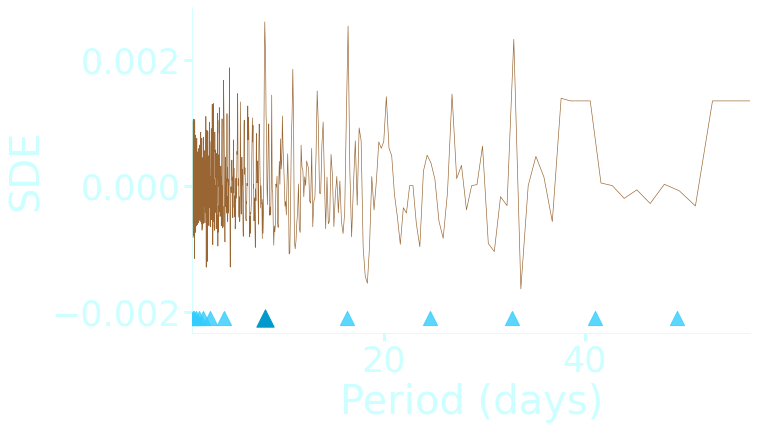

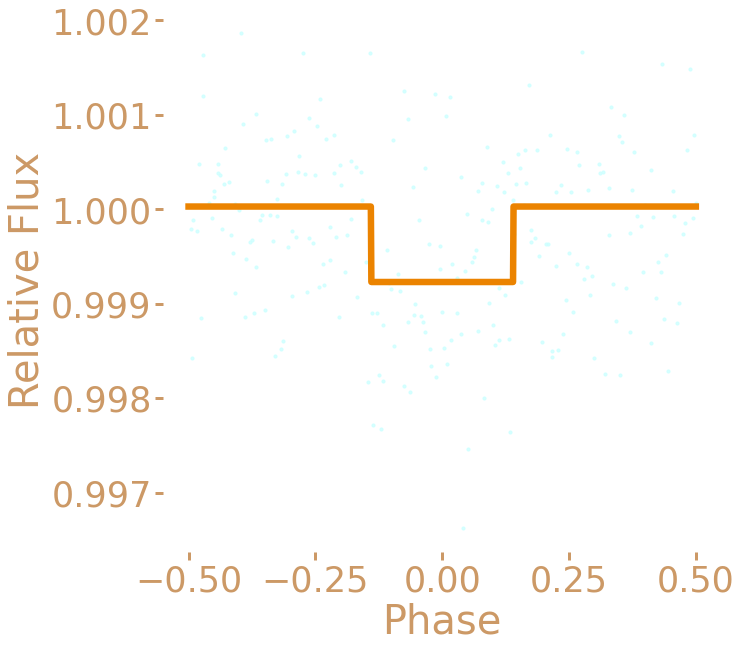

T0:  1628.9968383500045 duration:  0.28 npoints_dur:  1.0
done with multis  1 : 3
split indexes lengths:  [2043, 9954, 12277]
number of frequencies:  61719
return autoperiod [  1.           1.00001604   1.00003208 ...  99.70810454  99.86783239
 100.02807282]
period 19.098254664439544 index  59077


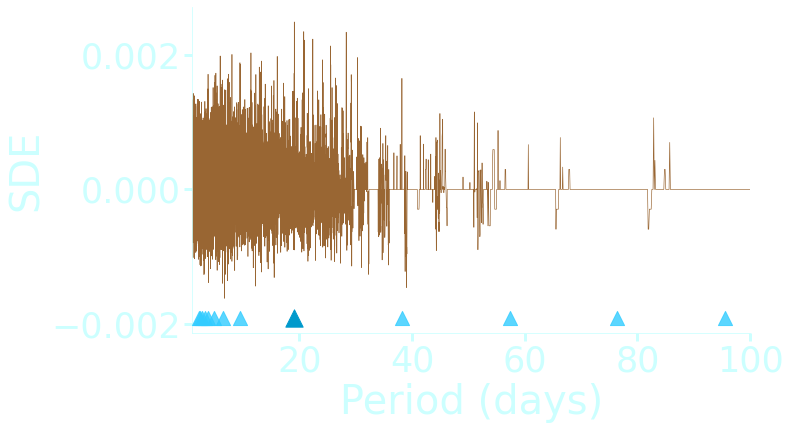

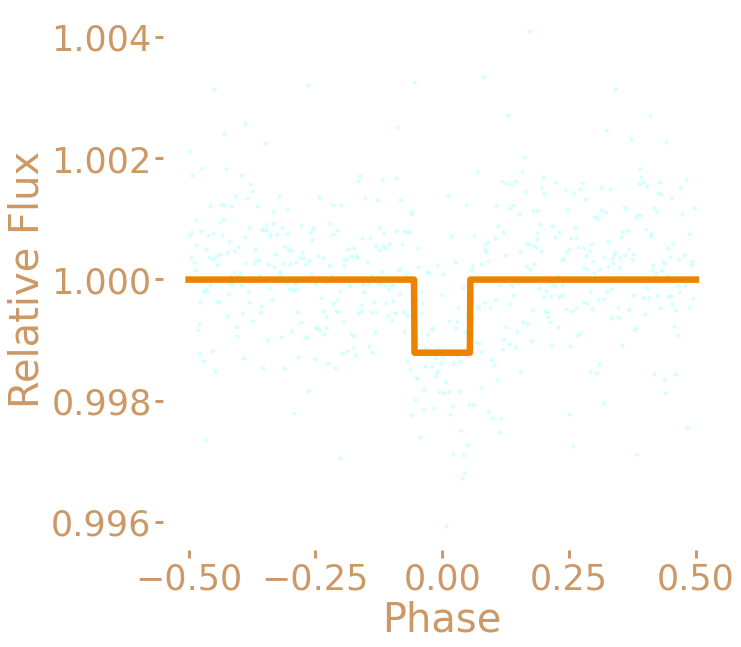

T0:  2045.1680586293885 duration:  0.11 npoints_dur:  1.0
done with multis  2 : 3
split indexes lengths:  [2043, 9954, 12277]
number of frequencies:  285500
return autoperiod [ 1.          1.00000347  1.00000694 ... 99.92211067 99.95674478
 99.9914029 ]
period 19.576507866809603 index  273652


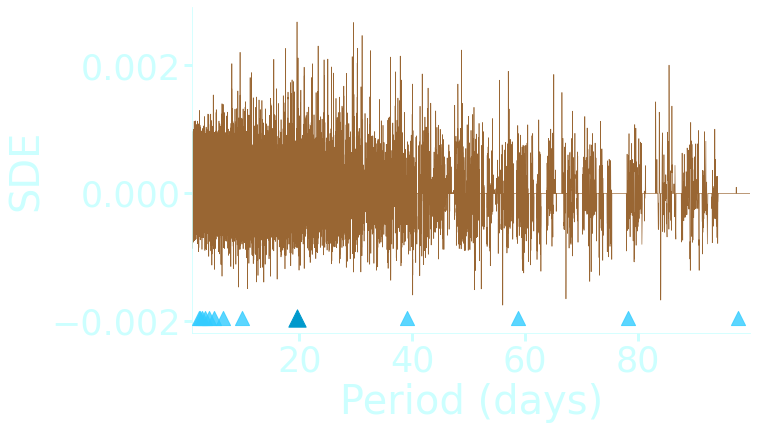

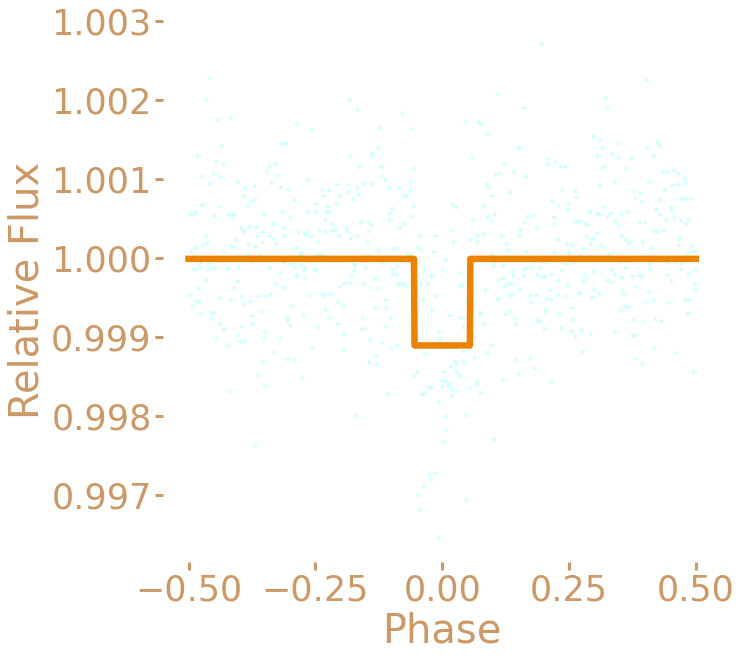

T0:  1640.4393716743677 duration:  0.11 npoints_dur:  1.0
done with multis  3 : 3
split indexes lengths:  [2043, 9954, 12277]


TypeError: only integer scalar arrays can be converted to a scalar index

In [24]:
column_names = ['TICID', 'planet_name', 'period', 'T0', 'Tdur', 'depth']

# final_file = './search_mdwarf_planets.csv'
new_planet_df = pd.DataFrame(columns=column_names)
print(new_planet_df)


for iii in TICIDs[:1]:
    
    print(iii)
    fits_files = sorted(glob.glob('./known_Mdwarfs_data/FFI_data/all_target_data/tic_'+str(iii)+'/*/*/*/*.fits'))
    print(len(fits_files))

#     fits_files = sorted(glob.glob('./known_Mdwarfs_data/FFI_data/*/*/*/*'+str(iii)+'*/*.fits'))

    if len(fits_files)>0:
    # print(tess_spoc_fits)
        print('num files', len(fits_files))
    #     fits_files
        ab, smass, smass_min, smass_max, sradius, sradius_min, sradius_max = get_catalog_info(iii, mdwarfs_known)
        print(ab)
        
        print('running periodic search')
        periods_multi, T0_multi, Tdur_multi, depth_multi, intransit, time_oot, flux_oot, flux_err_oot, indexes = running_periodic_search_per_mission(fits_files)
        pd.DataFrame({'time':time_oot, 'flux':flux_oot, 'flux_err':flux_err_oot}).to_csv('toi904_oot.csv', index = False)
        nnn = 0
        for jjj in range(len(T0_multi)):
            nnn+=1
            planet_name = str(float(iii)+nnn/100)
            
                

#             intransit = np.logical_or(intransit, transit_mask(time, results.period, 2*results.duration+(2*0.04), results.transit_time))
            
            new_planet_df.loc[len(new_planet_df.index)] = [int(iii), planet_name, periods_multi[jjj], T0_multi[jjj], Tdur_multi[jjj],depth_multi[jjj]]
#             new_planet_df.to_csv(final_file, index = False, header = False, mode="a",)
#         T0_all, Tdur_all, depth_all, periods_all = [], [], [], []
        print('done ', iii, new_planet_df)

In [ ]:
len(indexes)-1


In [ ]:
for i in range(len(indexes)):
    np.savetxt("indexes"+str(i)+".csv", indexes[i], delimiter=",")
    